In [1]:
import torch
import torchinfo
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import confusion_matrix

import dsutils 


import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
## Load some pretrained models

In [3]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)


utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet152.eval().to(device)
resnet50.eval().to(device)
resnet34.eval().to(device)
resnet18.eval().to(device)
alexnet.eval().to(device)

Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# filenames for imagenet sample images

fnames = os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test')

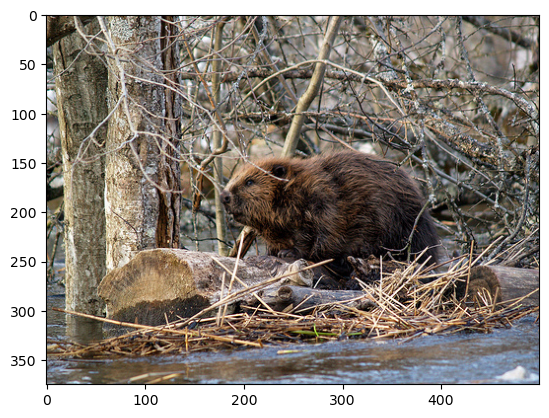

In [5]:
# Show an image

trial_image = fnames[15]
input_image = Image.open('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test/'+ trial_image)

plt.imshow(input_image)

In [6]:
# Define preprocessing 
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
# preprocess one image
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [8]:
# Test a model (run forward pass with test image)

with torch.no_grad():
    output = torch.nn.functional.softmax(alexnet(input_batch), dim=1)

results = utils.pick_n_best(predictions=output, n=3)

sample 0: [('beaver', '96.4%'), ('mink', '1.1%'), ('echidna, spiny anteater, anteater', '1.0%')]


In [9]:
## Extract Jacobians between the output and intermediate layers

In [10]:
# Extract the Jacobian

# AlexNet

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

# alexnet_part1 = nn.Sequential(*list(alexnet.features.children()))
# alexnet_part2 = alexnet.avgpool
# alexnet_part3 = nn.Sequential(*list(alexnet.classifier.children()))

module1 = list(alexnet.children())[:1]
module2 = list(alexnet.children())[1:2]

# anet_1st = nn.Sequential(*module1)

anet_1st = nn.Sequential(*[*module1, *module2, dsutils.Flatten()])

# anet_2nd = nn.Sequential(*[list(alexnet.children())[-1]])
anet_2nd = nn.Sequential(*[list(alexnet.children())[-1], dsutils.SoftMaxModule() ])

# anet_2nd = nn.Sequential(*module2)


with torch.no_grad():
    for inputs, _ in trainloader:
#         inputs, labels = data
        # x1 = alexnet_part1(inputs)
        # x2 = alexnet_part2(x1)
        # x3 = alexnet_part3(x2)
        x1 = anet_1st(inputs)
        x2 = anet_2nd(x1) 
        # output = torch.nn.functional.softmax(x2, dim=1) # check classifications
        
        # output = torch.nn.functional.softmax(alexnet(inputs), dim=1) # check classifications
        # firstlayer = alexnet.features[0:4](inputs)

# jacobian = torch.autograd.functional.jacobian(anet_2nd, x1)


In [14]:
x2.shape

torch.Size([1029, 1000])

In [15]:
Js_anet = []
for i in np.arange(x2.shape[0]):
    jacobian_anet = torch.autograd.functional.jacobian(anet_2nd, x1[i,:])
    Js_anet.append(jacobian_anet)
    print(i)

np.save('anet_Jacobian_rbyN_images1to1029.npy', Js_anet)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

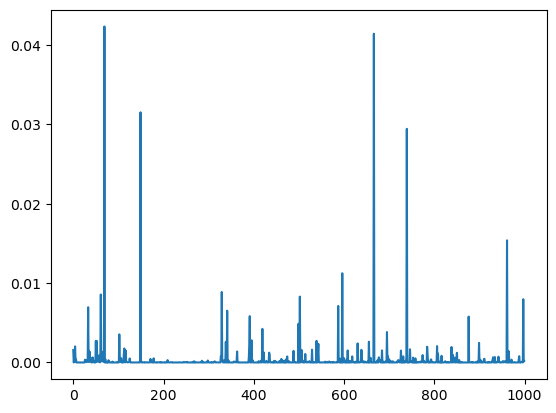

In [24]:
# plt.plot(np.linalg.norm(Js_anet[0].numpy(),axis=1))
# plt.plot(np.linalg.norm(Js_anet[3].numpy(),axis=1))
plt.plot(np.linalg.norm(Js_anet[666].numpy(),axis=1))
# plt.plot(np.linalg.norm(Js_anet[19].numpy(),axis=1))

In [17]:
results = utils.pick_n_best(predictions=x2, n=3)

sample 0: [('tench, Tinca tinca', '97.6%'), ('banded gecko', '1.5%'), ('sturgeon', '0.4%')]
sample 1: [('goldfish, Carassius auratus', '100.0%'), ('tench, Tinca tinca', '0.0%'), ('rock beauty, Holocanthus tricolor', '0.0%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '86.8%'), ('tiger shark, Galeocerdo cuvieri', '3.7%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '2.3%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '99.5%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.3%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 4: [('swimming trunks, bathing trunks', '91.7%'), ('sarong', '4.4%'), ('bikini, two-piece', '0.8%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '98.3%'), ('stingray', '1.6%'), ('muzzle', '0.0%')]
sample 6: [('stingray', '60.8%'), ('electric ray, crampfish, numbfish, torpedo', '36.8%'), ('sea slug, nudibranch', '0.9%

In [62]:
# Extract the Jacobian

# ResNet

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

# alexnet_part1 = nn.Sequential(*list(alexnet.features.children()))
# alexnet_part2 = alexnet.avgpool
# alexnet_part3 = nn.Sequential(*list(alexnet.classifier.children()))

module1 = list(resnet50.children())[:6]
module2 = list(resnet50.children())[6:]

# anet_1st = nn.Sequential(*module1)

rnet50_1st = nn.Sequential(*[*module1, dsutils.Flatten()])

# anet_2nd = nn.Sequential(*[list(alexnet.children())[-1]])
rnet50_2nd = nn.Sequential(*[*module2, dsutils.SoftMaxModule() ])

# anet_2nd = nn.Sequential(*module2)



with torch.no_grad():
    for inputs, _ in trainloader:
#         inputs, labels = data
        # x1 = alexnet_part1(inputs)
        # x2 = alexnet_part2(x1)
        # x3 = alexnet_part3(x2)
        y1 = rnet50_1st(inputs)
        y2 = rnet50_2nd(y1) 
        # output = torch.nn.functional.softmax(x2, dim=1) # check classifications
        
        output = torch.nn.functional.softmax(resnet50(inputs), dim=1) # check classifications
        # firstlayer = alexnet.features[0:4](inputs)

# jacobian = torch.autograd.functional.jacobian(anet_2nd, x1)


In [ ]:
y2.shape

In [122]:
results = utils.pick_n_best(predictions=y2, n=3)

sample 0: [('tench, Tinca tinca', '78.6%'), ('goldfish, Carassius auratus', '1.1%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '0.7%')]
sample 1: [('goldfish, Carassius auratus', '82.1%'), ('tench, Tinca tinca', '0.6%'), ('rock beauty, Holocanthus tricolor', '0.2%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '79.1%'), ('tiger shark, Galeocerdo cuvieri', '11.6%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '78.3%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.6%'), ('hammerhead, hammerhead shark', '0.1%')]
sample 4: [('hammerhead, hammerhead shark', '70.8%'), ('swimming trunks, bathing trunks', '10.4%'), ('eel', '2.1%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '50.6%'), ('stingray', '12.0%'), ('window screen', '0.3%')]
sample 6: [('stingray', '52.1%'), ('electric ray, crampfish, numbfish

In [76]:
jacobian_rnet50 = torch.autograd.functional.jacobian(rnet50_2nd, y1[333,:])

In [64]:
Js_rn50 = []
for i in np.arange(20): #np.arange(y2.shape[0]):
    jacobian_rn50 = torch.autograd.functional.jacobian(rnet50_2nd, y1[i,:])
    Js_rn50.append(jacobian_rn50)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [102]:
Js_rn50[0].shape

torch.Size([1000, 2048])

In [135]:
image = 6
norm_Jac_norms_rn50 = np.linalg.norm(Js_rn50[image].numpy(),axis=1)/np.max(np.linalg.norm(Js_rn50[image].numpy(),axis=1))
norm_Jac_norms_anet = np.linalg.norm(Js_anet[image].numpy(),axis=1)/np.max(np.linalg.norm(Js_anet[image].numpy(),axis=1))


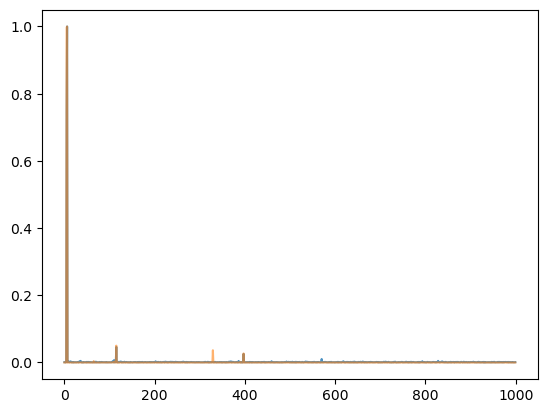

In [136]:
plt.plot(norm_Jac_norms_rn50,alpha=0.8)
plt.plot(norm_Jac_norms_anet,alpha=0.6)

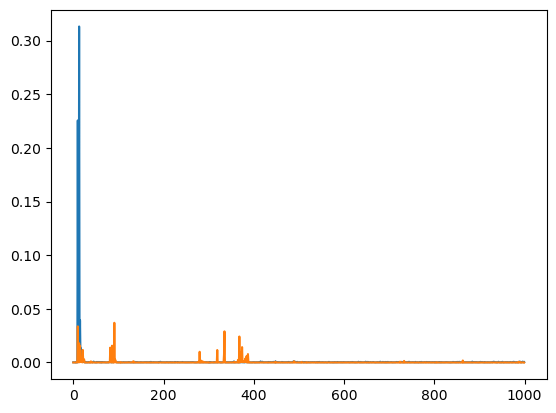

In [85]:
plt.plot(np.linalg.norm(Js_rn50[13].numpy(),axis=1))
plt.plot(np.linalg.norm(Js_anet[13].numpy(),axis=1))

In [144]:
import metrics

image = 2

A = Js_rn50[image]@Js_rn50[image].T
B = Js_anet[image]@Js_anet[image].T

db2 = metrics.sq_bures_metric(A.numpy(),B.numpy())

In [163]:
Js_rn50[0].shape[1]

2048

In [165]:
db2 = []
Nrn50 = Js_rn50[0].shape[1]
Nanet = Js_anet[0].shape[1]
for i in np.arange(len(Js_rn50)):
    A = Js_rn50[i]@Js_rn50[i].T
    B = Js_anet[i]@Js_anet[i].T
    db2.append(metrics.sq_bures_metric((1/Nrn50)**2 * A.numpy(),(1/Nanet)**2 * B.numpy()))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [166]:
np.argmax(db2)

np.int64(6)

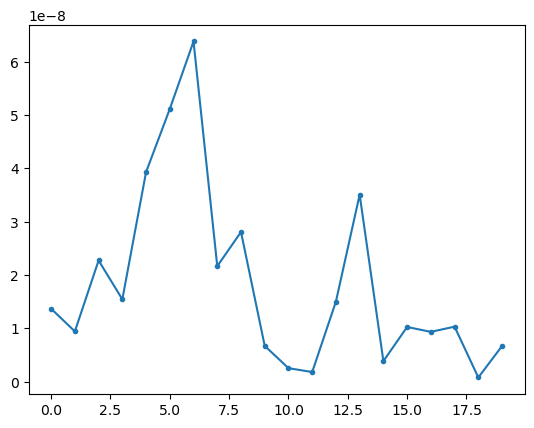

In [170]:
plt.plot(db2,'.-')

In [ ]:
# To do:

# figure out what to do with conv layers 
# Compute bures distance between jacobians